# Introduction to Bayesian Inference via Grid Methods

by Henry Bechtel 

Many introductions to Bayesian analysis tend to be too simplistic or too complex. I think grid methods offer great insight into how Bayesian inference works that can go beyond simple, toy examples and can also show why MCMC methods are required for more complex problems.

I'm going to be using a lot of for-loops in my grids and since Julia is great with loops, I'm using it to make things a little more snappy.

Special thanks to excellent, inspirational work by Allen Downey, Richard McElreath, and Brandon Rohrer.

In [1]:
using Plots, Distributions

In [2]:
mean_true = 20
sig_true = 2

2

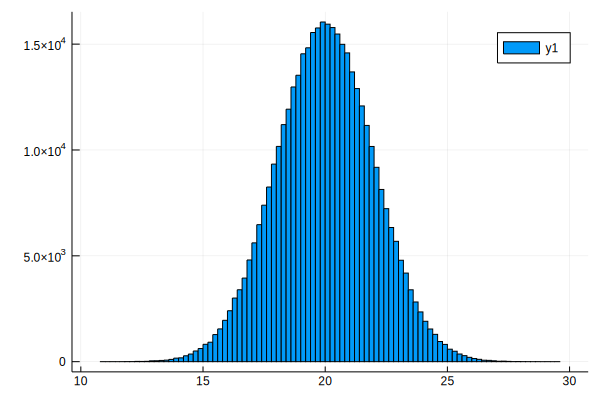

In [3]:
Plots.histogram((mean_true .+ sig_true*randn(400000)), bins=100)

# Simulating the "Truth"

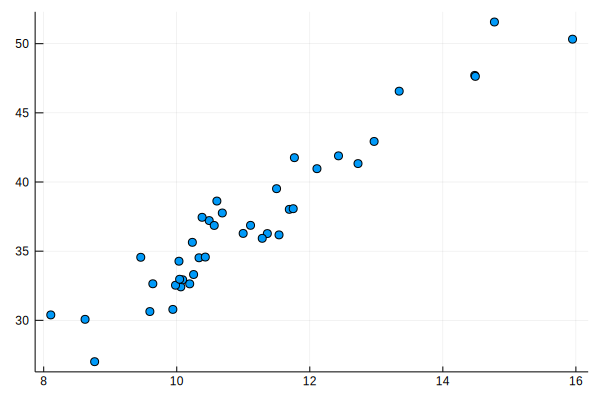

In [58]:
b0_true = 4
b1_true = 3
s_true = 2
num_observations = 40

x = 11 .+ randn(num_observations)*2
y = b0_true .+ b1_true*x .+ randn(length(x))*s_true;

scatter(x,y, legend=false)

# Infering the "Truth"

In [65]:
hyp_b0 = LinRange(0, 8, 101)
hyp_b1 = LinRange(0, 8, 101)
hyp_s = LinRange(0.01, 8, 101);

In [66]:
prior = ones(length(hyp_b0),length(hyp_b1),length(hyp_s))
unnormalized_posterior = zeros(size(prior));

In [67]:
marginal_likelihood = 0
for i in 1:length(hyp_b0)
    b0 = hyp_b0[i]
    for j in 1:length(hyp_b1)
        b1 = hyp_b1[j]
        for k in 1:length(hyp_s)
            s = hyp_s[k]
            unnormalized_likelihood = 1
            for d in 1:length(y)
                mean = b0 + b1*x[d]
                unnormalized_likelihood *= pdf(Normal(mean,s),y[d])
            end
            unnormalized_posterior[i,j,k] = unnormalized_likelihood*prior[i,j,k]
            marginal_likelihood += unnormalized_likelihood*prior[i,j,k]
        end
    end
end

posterior = unnormalized_posterior/marginal_likelihood;

In [68]:
val, idx = findmax(posterior[:,:,:])
idx

CartesianIndex(22, 41, 22)

In [69]:
println("Max Posterior Estimate for b0 is: ", hyp_b0[idx[1]])
println("Max Posterior Estimate for b1 is: ", hyp_b1[idx[2]])
println("Max Posterior Estimate for s is: ", hyp_s[idx[3]])

Max Posterior Estimate for b0 is: 1.68
Max Posterior Estimate for b1 is: 3.2
Max Posterior Estimate for s is: 1.6879


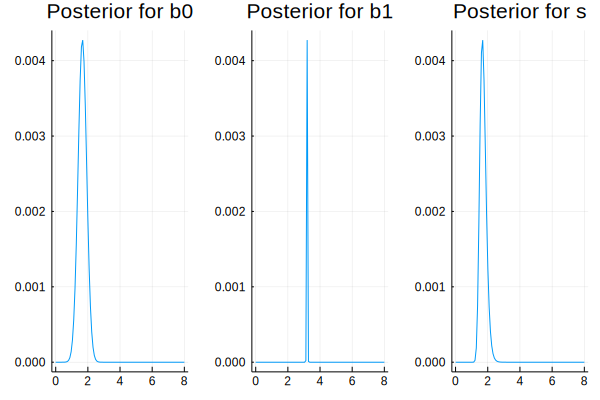

In [70]:
p1 = plot(hyp_b0, posterior[:,idx[2],idx[3]], title="Posterior for b0")
p2 = plot(hyp_b1, posterior[idx[1],:,idx[3]], title="Posterior for b1")
p3 = plot(hyp_s, posterior[idx[1],idx[2],:], title="Posterior for s")
plot(p1,p2,p3, layout=(1,3), legend=false)

Sampling from the posterior (under construction)

In [263]:
i = rand(1:length(hyp_b0))
j = rand(1:length(hyp_b1))
k = rand(1:length(hyp_s))

posterior[i,j,k]



1.188591282930557e-203